### Import Dependencies

In [3]:
import time
import os
import glob
import shutil
import random
import regex
import IPython
from tqdm import tqdm

import pandas as pd 
import numpy as np
from PIL import Image, ImageChops
import cv2
import pyarrow.parquet as pq
import albumentations as A

DATA_DIR = "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting"

### BengaliAI Dataset

In [3]:
!unzip -qq "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/bengaliai-cv19.zip"  \
        -d "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/bengaliai-cv19/"

In [2]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "bengaliai-cv19/train.csv"))
class_map_df = pd.read_csv(os.path.join(DATA_DIR, "bengaliai-cv19/class_map.csv"))

display(train_df.head())
display(class_map_df.head())

print(f'Size of training data: {train_df.shape}')
print(f'Size of class map: {class_map_df.shape}')

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


Size of training data: (200840, 5)
Size of class map: (186, 3)


In [3]:
cm_gr = class_map_df.loc[(class_map_df.component_type=='grapheme_root'), 'component'].values
cm_vd = class_map_df.loc[(class_map_df.component_type=='vowel_diacritic'), 'component'].values  
cm_cd = class_map_df.loc[(class_map_df.component_type=='consonant_diacritic'), 'component'].values   

print(f"grapheme root:\n{15*'-'}\n{cm_gr}\n\n vowel diacritic:\n{18*'-'}\n{cm_vd}\n\n consonant diacritic:\n{20*'-'}\n {cm_cd}\n\n")

print(f"Total grapheme roots: {cm_gr.size}")
print(f"Total vowel diacritics: {cm_vd.size}")
print(f"Total consonet diacritics: {cm_cd.size}")
print(f"Subtotal: {class_map_df.shape[0]}")

grapheme root:
---------------
['ং' 'ঃ' 'অ' 'আ' 'ই' 'ঈ' 'উ' 'ঊ' 'ঋ' 'এ' 'ঐ' 'ও' 'ঔ' 'ক' 'ক্ক' 'ক্ট' 'ক্ত'
 'ক্ল' 'ক্ষ' 'ক্ষ্ণ' 'ক্ষ্ম' 'ক্স' 'খ' 'গ' 'গ্ধ' 'গ্ন' 'গ্ব' 'গ্ম' 'গ্ল'
 'ঘ' 'ঘ্ন' 'ঙ' 'ঙ্ক' 'ঙ্ক্ত' 'ঙ্ক্ষ' 'ঙ্খ' 'ঙ্গ' 'ঙ্ঘ' 'চ' 'চ্চ' 'চ্ছ'
 'চ্ছ্ব' 'ছ' 'জ' 'জ্জ' 'জ্জ্ব' 'জ্ঞ' 'জ্ব' 'ঝ' 'ঞ' 'ঞ্চ' 'ঞ্ছ' 'ঞ্জ' 'ট'
 'ট্ট' 'ঠ' 'ড' 'ড্ড' 'ঢ' 'ণ' 'ণ্ট' 'ণ্ঠ' 'ণ্ড' 'ণ্ণ' 'ত' 'ত্ত' 'ত্ত্ব'
 'ত্থ' 'ত্ন' 'ত্ব' 'ত্ম' 'থ' 'দ' 'দ্ঘ' 'দ্দ' 'দ্ধ' 'দ্ব' 'দ্ভ' 'দ্ম' 'ধ'
 'ধ্ব' 'ন' 'ন্জ' 'ন্ট' 'ন্ঠ' 'ন্ড' 'ন্ত' 'ন্ত্ব' 'ন্থ' 'ন্দ' 'ন্দ্ব' 'ন্ধ'
 'ন্ন' 'ন্ব' 'ন্ম' 'ন্স' 'প' 'প্ট' 'প্ত' 'প্ন' 'প্প' 'প্ল' 'প্স' 'ফ' 'ফ্ট'
 'ফ্ফ' 'ফ্ল' 'ব' 'ব্জ' 'ব্দ' 'ব্ধ' 'ব্ব' 'ব্ল' 'ভ' 'ভ্ল' 'ম' 'ম্ন' 'ম্প'
 'ম্ব' 'ম্ভ' 'ম্ম' 'ম্ল' 'য' 'র' 'ল' 'ল্ক' 'ল্গ' 'ল্ট' 'ল্ড' 'ল্প' 'ল্ব'
 'ল্ম' 'ল্ল' 'শ' 'শ্চ' 'শ্ন' 'শ্ব' 'শ্ম' 'শ্ল' 'ষ' 'ষ্ক' 'ষ্ট' 'ষ্ঠ' 'ষ্ণ'
 'ষ্প' 'ষ্ফ' 'ষ্ম' 'স' 'স্ক' 'স্ট' 'স্ত' 'স্থ' 'স্ন' 'স্প' 'স্ফ' 'স্ব'
 'স্ম' 'স্ল' 'স্স' 'হ' 'হ্ন' 'হ্ব' 'হ্ম' 'হ্ল' 'ৎ' 'ড়' 'ঢ়' 'য়']

 vowel diacritic:
--------

In [4]:
print(f"Unique Graphemes: {train_df.grapheme.nunique()}")

Unique Graphemes: 1295


In [11]:
start_time = time.time()
train_0_df = pd.read_parquet(os.path.join(DATA_DIR, "bengaliai-cv19/train_image_data_0.parquet"))
print(f"`train_image_data_0` read in {round(time.time()-start_time, 2)} sec.")

`train_image_data_0` read in 41.84 sec.


### Create and crop grapheme images

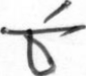

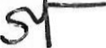

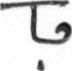

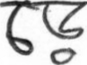

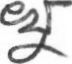

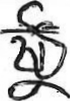

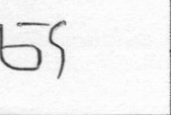

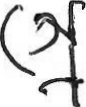

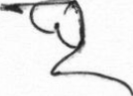

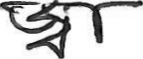

In [12]:
"""
Old method
"""

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
        
        
def display_image_from_data_old(data_df):

    for i, index in enumerate(data_df.index):
        
        # Read the image and reshape. (The image is already in b&w)
        image_id = data_df.iloc[i]['image_id']
        flattened = data_df.iloc[i].drop('image_id').values.astype(np.uint8)
        reshaped = flattened.reshape(137, 236)
        unpacked = Image.fromarray(reshaped)
        trimmed = trim(unpacked)
        
        if trimmed == None:
            # take otsu's threshold
            ret, threshed = cv2.threshold(reshaped, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            display(Image.fromarray(threshed))

            # Morph-op to remove noise
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (44, 44))        
            morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
            # display(Image.fromarray(morphed))

            # Find the max-area contour
            cntrs, _ = cv2.findContours(morphed, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
            cntr = sorted(cntrs, key=cv2.contourArea)[-1]

            # Crop and save it
            x,y,w,h = cv2.boundingRect(cntr)
            dst = reshaped[y:y+h, x:x+w]
            display(Image.fromarray(dst))
            
        display(trimmed)
        
df = train_0_df.sample(10)
display_image_from_data_old(df)

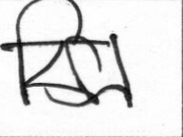

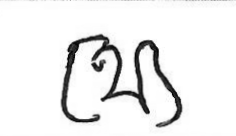

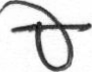

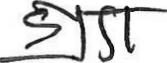

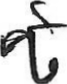

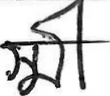

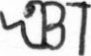

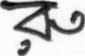

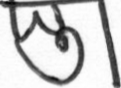

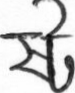

In [13]:
def display_image_from_data(data_df):

    for i, index in enumerate(data_df.index):
        
        # Read the image and reshape. (The image is already in b&w)
        image_id = data_df.iloc[i]['image_id']
        # print(image_id)
        flattened = data_df.iloc[i].drop('image_id').values.astype(np.uint8)
        reshaped = flattened.reshape(137, 236)
        # display(Image.fromarray(reshaped))
        
        # take otsu's threshold
        ret, threshed = cv2.threshold(reshaped, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        display(Image.fromarray(threshed))

        # Morph-op to remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (57, 57))        
        morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
        # display(Image.fromarray(morphed))
        
        # Find the max-area contour
        cntrs, _ = cv2.findContours(morphed, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
        cntr = sorted(cntrs, key=cv2.contourArea)[-1]

        # Crop and save it
        x,y,w,h = cv2.boundingRect(cntr)
        dst = reshaped[y:y+h, x:x+w]
        display(Image.fromarray(dst))
        # display(trim(Image.fromarray(dst)))


df = train_0_df.sample(10)
#display_image_from_data(df)
display_image_from_data_old(df)

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "bengaliai-cv19/train.csv"))

im_id = 0
im_dict = 0

try:
    # Create  Directory  MyDirectory 
    os.mkdir(os.path.join(DATA_DIR, "grapheme_images"))
except FileExistsError:
    ##print if directory already exists
    print("Directory already exists.")


# read
for i in range(4):
    df = pq.read_table(source=os.path.join(DATA_DIR, "bengaliai-cv19/train_image_data_{}.parquet".format(i))).to_pandas()

    im_dict = i * 50210
    for j in tqdm(range(len(df))):
        
        # Read the image and reshape. (The image is already in b&w)
        image_id = df.iloc[j]['image_id']
        # print(image_id)
        flattened = df.iloc[j].drop('image_id').values.astype(np.uint8)
        reshaped = flattened.reshape(137, 236)
        # display(Image.fromarray(reshaped))
        
        # take otsu's threshold
        ret, threshed = cv2.threshold(reshaped, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        # display(Image.fromarray(threshed))

        # Morph-op to remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (57, 57))        
        morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
        # display(Image.fromarray(morphed))
        
        # Find the max-area contour
        cntrs, _ = cv2.findContours(morphed, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
        cntr = sorted(cntrs, key=cv2.contourArea)[-1]

        # Crop and save it
        x,y,w,h = cv2.boundingRect(cntr)
        dst = reshaped[y:y+h, x:x+w]
        Image.fromarray(dst).save(os.path.join(DATA_DIR, "grapheme_images/" + str(train_df.iloc[im_dict]['grapheme'])+"_{}.jpg".format(im_id)))

        im_id += 1
        im_dict += 1
    

In [14]:
grapheme_imgs = glob.glob(os.path.join(DATA_DIR, "grapheme_images/*"))
print(len(grapheme_imgs))

200840


ক্ট্রো


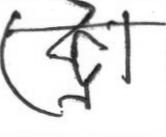

হ


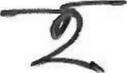

খ্রী


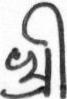

র্টি


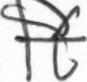

থ্রো


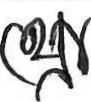

In [15]:
for i in grapheme_imgs[:5]:
    print(i.split('/')[-1].split('.')[0].split('_')[0])
    display(IPython.display.Image(filename=i))

### Create a dictionary of graphemes

In [7]:
def normalize_word(word):

    if 'ো' in word: word = word.replace('ো', 'ো')
    
    if 'ৗ' in word:    
        if 'ৌ' in word: word = word.replace('ৌ', 'ৌ') 
        else: word = word.replace('ৗ', 'ী') # 'ৗ' without 'ে' is replaced by 'ী'
    
    if '়' in word:
        if 'ব়' in word: word = word.replace('ব়', 'র')
        if 'য়' in word: word = word.replace('য়', 'য়')
        if 'ড়' in word: word = word.replace('ড়', 'ড়')
        if 'ঢ়' in word: word = word.replace('ঢ়', 'ঢ়')
        if '়' in word: word = word.replace('়', '') # discard any other '়' without 'ব'/'য'/'ড'/'ঢ'
        
    # visually similar '৷' (Bengali Currency Numerator Four) is replaced by '।' (Devanagari Danda)
    if '৷' in word: word = word.replace('৷', '।')
    
    return word

In [16]:
grapheme_dict = {}

for i in grapheme_imgs:
    key = normalize_word(i.split('/')[-1].split('.')[-2].split('_')[-2])
    try:
        grapheme_dict[key].append(i)
    except KeyError:
        grapheme_dict[key] = [i]
        
print(len(grapheme_dict))

1295


In [17]:
for key in grapheme_dict:
    print(len(grapheme_dict[key]))

164
151
143
162
164
174
148
170
169
147
170
171
141
143
177
166
143
160
135
145
133
147
143
164
164
148
168
166
168
170
149
171
150
170
145
151
169
129
150
137
157
155
162
170
149
149
161
166
147
144
166
145
165
153
137
169
171
161
151
143
174
160
118
168
166
135
168
150
151
170
143
147
143
177
173
169
164
166
148
168
175
162
153
166
148
136
151
171
146
145
149
169
150
136
142
170
147
163
141
151
165
145
173
166
153
162
164
165
153
163
149
148
168
176
142
137
150
145
151
170
138
166
152
143
154
167
150
152
153
168
149
159
146
146
173
149
167
129
165
158
171
147
164
148
164
171
151
149
174
167
138
152
145
148
167
154
175
168
173
152
165
175
176
148
166
151
135
150
168
162
149
145
150
144
147
165
135
148
151
131
141
149
174
148
169
148
147
171
178
158
155
154
172
167
151
135
177
139
145
170
169
133
168
166
171
145
138
170
154
148
170
147
151
151
163
178
153
149
138
134
165
144
173
148
152
166
136
173
173
147
169
167
146
173
151
165
167
176
176
138
168
174
164
170
163
151
134
143
145
133


### Ekush Dataset

In [19]:
!unzip -qq "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Ekush.zip" \
        -d "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/"
!unzip -qq "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Ekush/EkushImg/raw_image.zip" \
        -d "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Ekush/EkushImg/raw_image/"
!unzip -qq "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Ekush/EkushImg/raw_image/male.zip" \
        -d "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Ekush/EkushImg/raw_image/"
!unzip -qq "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Ekush/EkushImg/raw_image/female.zip" \
        -d "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Ekush/EkushImg/raw_image/"

In [18]:
ekush_imgs = glob.glob(os.path.join(DATA_DIR, "Ekush/EkushImg/raw_image/*/*/*jpg"))
print(len(ekush_imgs))

364047


In [19]:
ekush_labels = pd.read_csv(os.path.join(DATA_DIR, "Ekush/ekushCSV/metaDataCSV.csv"))

### Dataset label correction
x120 = ekush_labels.iloc[111]
x121 = ekush_labels.iloc[110]
    
for i in range(110, 120):
    ekush_labels.iloc[i] = ekush_labels.iloc[i+2]

ekush_labels.iloc[120] = x120
ekush_labels.iloc[121] = x121

ekush_labels

,Label,Char Name
0,0,া
1,1,ি
2,2,ী
3,3,ু
4,4,ূ
...,...,...
117,119,৭
118,120,৮
119,121,৯
120,111,ল্ত


ব্দ


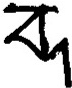

ব্দ


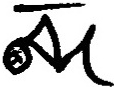

ব্দ


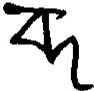

ব্দ


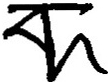

ব্দ


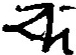

In [20]:
for i in ekush_imgs[300000:300005]:
    print(ekush_labels.loc[int(i.split('/')[-2]), "Char Name"])
    display(IPython.display.Image(filename=i))

In [21]:
for i in ekush_imgs:
    key = normalize_word(ekush_labels.loc[int(i.split('/')[-2]), "Char Name"])
    try:
        grapheme_dict[key].append(i)
    except KeyError:
        grapheme_dict[key] = [i]
        
print(len(grapheme_dict))

1368


In [22]:
for key in grapheme_dict:
    print(len(grapheme_dict[key]))

164
151
143
162
164
174
148
170
2269
147
170
171
141
143
177
166
143
160
135
145
133
147
143
164
3226
148
168
166
168
3231
149
171
150
3230
3188
151
169
129
150
137
157
155
162
170
149
149
161
166
147
144
166
145
165
153
137
169
171
161
151
3197
174
160
118
168
166
135
168
150
151
170
143
147
143
177
173
169
3208
166
148
168
175
162
153
166
148
136
151
171
146
145
149
169
150
136
142
170
147
163
141
151
165
145
173
166
153
162
164
3211
153
163
149
148
168
176
142
137
150
145
151
170
138
166
152
143
154
167
150
152
153
168
149
159
146
146
173
149
167
129
165
158
171
147
164
148
164
3431
151
149
174
167
138
152
145
148
167
154
175
168
173
152
165
175
176
148
166
151
135
150
168
162
149
145
150
144
147
165
135
148
151
131
141
149
174
148
169
148
147
171
178
158
155
154
172
167
151
135
177
139
145
170
169
133
168
166
171
145
138
170
154
148
170
147
151
151
163
178
153
149
138
134
165
144
173
148
152
166
136
173
173
147
169
167
146
173
151
165
167
176
176
138
2978
174
164
170
163
151
134
14

### BS Bangla Handwriting Dataset

In [29]:
"""
if 7zip is not installed on aws install by running:
    sudo amazon-linux-extras install epel
    sudo yum install -y p7zip
    sudo cp /usr/bin/7za /usr/bin/7z
"""

!7z x "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Boise_State_Bangla_Handwriting_Dataset_20200228.zip" \
    -o"/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/"
!mv "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Boise State Bangla Handwriting Dataset 20200228" \
    "/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting"


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /home/ec2-user/word_level_ocr/pritom/datasets/handwritin                                                                  1 file, 6611219491 bytes (6305 MiB)

Extracting archive: /home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Boise_State_Bangla_Handwriting_Dataset_20200228.zip
 11% 256 Ope            
ERRORS:
Headers Error

--
Path = /home/ec2-user/word_level_ocr/pritom/datasets/handwriting/Boise_State_Bangla_Handwriting_Dataset_20200228.zip
Type = zip
ERRORS:
Headers Error
Physical Size = 6611219491
64-bit = +

      0% 290 - Boise State Bangla Handwriting  . 1. Camera/1. Essay/Page032a.j                                                                            0% 342 - Boise State Bangla Handwriting  . 1. Camera/1. 

In [35]:
try:
    # Create  Directory  MyDirectory 
    os.mkdir(os.path.join(DATA_DIR, "bs_chars"))
except FileExistsError:
    ##print if directory already exists
    print("Directory already exists.")

hw_chars_coord = glob.glob(os.path.join(DATA_DIR, "BS_Bangla_Handwriting/**/*.txt"), recursive=True)
try:
    hw_chars_coord.remove(os.path.join(DATA_DIR, "BS_Bangla_Handwriting/4. Demographic.txt"))
    hw_chars_coord.remove(os.path.join(DATA_DIR, "BS_Bangla_Handwriting/README.txt"))
except ValueError: 
    print("File doesn't exist in list")

length = len(hw_chars_coord)

char_counter = 0

for page in tqdm(hw_chars_coord):
    with open(page, 'r') as coordfile:
        image_dir, image_name =  page.split("/Character")
        image_name = image_name.split('/')[-1].replace(".txt", ".jpg")
        # print(image_dir)
        # print(image_name)
        image_path = image_dir + "/" + image_name
        # print(image_path)
        image = cv2.imread(image_path)
        if image is None:
                image_path = image_path.replace(".jpg", ".tif")
                # print(image_path)
                image = cv2.imread(image_path)
        
        if image is None:
            print(image_path + "\n Doesn't exist")
            continue
            
        for line in coordfile:
            
            char_counter += 1
            
            try:
                coordinates = line.split()[-1].split(',')
                label = line.split()[-3]
            except IndexError:
                print("Faulty coordinate or label on line")
            
            char_img = image[int(coordinates[1]):int(coordinates[1])+int(coordinates[3]), int(coordinates[0]):int(coordinates[0])+int(coordinates[2])]
            # print(label)
            # display(Image.fromarray(char_img))
            # print(os.path.join(DATA_DIR, "bs_chars", str(char_counter) + "_" + label + ".jpg"))
            if char_img.shape[0] == 0 or char_img.shape[1] == 0:
                continue
            cv2.imwrite(os.path.join(DATA_DIR, "bs_chars", str(char_counter) + "_" + label + ".jpg"), char_img)


Directory already exists.


 20%|████████████▎                                               | 222/1085 [00:31<02:44,  5.24it/s]

/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/1. Essay/Page220a.tif
 Doesn't exist


 31%|██████████████████▍                                         | 334/1085 [00:46<00:58, 12.87it/s]

Faulty coordinate or label on line


 32%|███████████████████▏                                        | 346/1085 [00:47<00:55, 13.25it/s]

/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/2. Isolated Character/page089b.tif
 Doesn't exist


 39%|███████████████████████▍                                    | 424/1085 [00:52<00:15, 43.05it/s]

/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/2. Isolated Character/Page151b.tif
 Doesn't exist
/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/2. Isolated Character/Page152b.tif
 Doesn't exist
/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/2. Isolated Character/Page153b.tif
 Doesn't exist
/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/2. Isolated Character/Page154b.tif
 Doesn't exist
/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/2. Isolated Character/Page155b.tif
 Doesn't exist
/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/2. Isolated Character/Page156b.tif
 Doesn't exist
/home/ec2-user/word_level_ocr/pritom/datasets/handwriting/BS_Bangla_Handwriting/1. Camera/2. Isolated Character/Page157b.tif
 Doesn't exist
/home/ec2-user/word_

 94%|███████████████████████████████████████████████████████▋   | 1023/1085 [02:15<00:09,  6.51it/s]

Faulty coordinate or label on line


 95%|███████████████████████████████████████████████████████▉   | 1029/1085 [02:16<00:11,  4.91it/s]

Faulty coordinate or label on line


 95%|████████████████████████████████████████████████████████▏  | 1033/1085 [02:17<00:09,  5.65it/s]

Faulty coordinate or label on line
Faulty coordinate or label on line


 96%|████████████████████████████████████████████████████████▍  | 1037/1085 [02:18<00:11,  4.10it/s]

Faulty coordinate or label on line


 97%|█████████████████████████████████████████████████████████▎ | 1053/1085 [02:21<00:04,  6.54it/s]

Faulty coordinate or label on line
Faulty coordinate or label on line


 98%|█████████████████████████████████████████████████████████▌ | 1059/1085 [02:22<00:03,  6.62it/s]

Faulty coordinate or label on line


 98%|█████████████████████████████████████████████████████████▊ | 1063/1085 [02:23<00:03,  6.46it/s]

Faulty coordinate or label on line
Faulty coordinate or label on line


 98%|█████████████████████████████████████████████████████████▉ | 1066/1085 [02:23<00:02,  6.43it/s]

Faulty coordinate or label on line
Faulty coordinate or label on line


 99%|██████████████████████████████████████████████████████████▍| 1074/1085 [02:24<00:01,  6.35it/s]

Faulty coordinate or label on line


100%|███████████████████████████████████████████████████████████| 1085/1085 [02:26<00:00,  7.41it/s]


In [23]:
bschar_imgs = glob.glob(os.path.join(DATA_DIR, "bs_chars/*jpg"))
print(len(bschar_imgs))

237714


অ


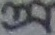

ন


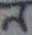

ন্য


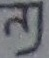

ভূ


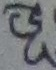

প্রা


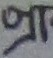

In [24]:
for i in bschar_imgs[:5]:
    print(i.split('/')[-1].split("_")[-1].split(".")[0])
    display(IPython.display.Image(filename=i))

In [25]:
for i in bschar_imgs:
    key = normalize_word(i.split('/')[-1].split("_")[-1].split(".")[0])
    try:
        grapheme_dict[key].append(i)
    except KeyError:
        grapheme_dict[key] = [i]
        
print(len(grapheme_dict))

1432


In [26]:
for key in grapheme_dict:
    print(len(grapheme_dict[key]))

164
2095
145
162
164
174
148
170
2331
147
170
171
141
211
177
166
143
160
135
145
133
147
143
164
3294
148
168
166
168
3304
650
171
150
3311
3260
151
169
129
150
137
224
227
238
170
149
149
229
166
147
160
166
146
167
4378
137
169
670
161
151
3708
174
160
177
224
166
151
168
150
152
173
143
201
1098
690
666
169
3282
166
148
168
176
162
153
166
148
138
151
171
146
145
149
170
150
4885
142
240
147
163
141
151
644
623
173
166
153
162
164
3280
14122
163
149
148
168
242
142
137
220
145
151
170
626
166
1110
143
222
167
154
152
1921
168
149
630
146
146
173
1650
167
129
165
158
171
147
164
148
164
3431
173
149
1292
167
138
152
147
148
167
154
175
169
667
152
165
175
176
148
166
785
137
150
237
162
149
146
634
144
147
165
141
148
641
133
141
149
176
148
169
148
147
171
178
158
648
154
261
167
151
135
177
354
608
170
169
133
642
166
171
145
201
170
154
700
173
147
151
151
302
2226
153
149
138
134
165
144
173
626
154
166
205
173
3315
148
169
172
146
173
153
165
167
176
176
138
3048
174
1147
170
1

In [27]:
for key, value in list(grapheme_dict.items()):
    if len(grapheme_dict[key]) < 10:
        del grapheme_dict[key]
        
print(len(grapheme_dict))

1393


In [28]:
for key in grapheme_dict:
    print(len(grapheme_dict[key]))

164
2095
145
162
164
174
148
170
2331
147
170
171
141
211
177
166
143
160
135
145
133
147
143
164
3294
148
168
166
168
3304
650
171
150
3311
3260
151
169
129
150
137
224
227
238
170
149
149
229
166
147
160
166
146
167
4378
137
169
670
161
151
3708
174
160
177
224
166
151
168
150
152
173
143
201
1098
690
666
169
3282
166
148
168
176
162
153
166
148
138
151
171
146
145
149
170
150
4885
142
240
147
163
141
151
644
623
173
166
153
162
164
3280
14122
163
149
148
168
242
142
137
220
145
151
170
626
166
1110
143
222
167
154
152
1921
168
149
630
146
146
173
1650
167
129
165
158
171
147
164
148
164
3431
173
149
1292
167
138
152
147
148
167
154
175
169
667
152
165
175
176
148
166
785
137
150
237
162
149
146
634
144
147
165
141
148
641
133
141
149
176
148
169
148
147
171
178
158
648
154
261
167
151
135
177
354
608
170
169
133
642
166
171
145
201
170
154
700
173
147
151
151
302
2226
153
149
138
134
165
144
173
626
154
166
205
173
3315
148
169
172
146
173
153
165
167
176
176
138
3048
174
1147
170
1

In [29]:
for key in grapheme_dict:
    if len(grapheme_dict[key]) < 100:
        print(key)

ধ্বে
ঙ্গোঁ
কোঁ
ল্ভ
১০
স্হা
স্ল
ক্ব
গ্বি
থ্বী
প্সা
ব্জা
ম্ফ
ল্গা
ল্ফ
শ্ছে
স্খ
স্প্লা
স্ফা
হ্ণ


### Extract graphemes from a word

In [8]:
def extract_graphemes(word):
    graphemes = regex.findall(r'\X', word)
    postproc_gr = []

    i = 0
    length = len(graphemes)
    while i < length:

        if graphemes[i][-1] == "্":
            postproc_gr.append(graphemes[i])
            while graphemes[i][-1] == "্" and i+1 < length:
                postproc_gr[-1] += graphemes[i+1]
                i += 1

        elif graphemes[i][-1] == 'ং' or graphemes[i][-1] == 'ঃ':
            postproc_gr.append(graphemes[i][:-1])
            postproc_gr.append(graphemes[i][-1])

        else:
            postproc_gr.append(graphemes[i])

        i += 1

    return postproc_gr

word = 'এটাশুধুমাত্রসেনিটিচেকযেনরমালশব্দেঠিকআছেকিনা'
word1 = 'রেফর্রাম্যর্রর্য্যষ্ঠ্রযপড়্রুঢ়পদ্ভাংঠ্য্যঙ্র্যাডৃপটেরন্ঙ'
word2 = "দম্বোন্দ্রগৃন্থগ্নীল্লীর্কঙলীত্যেদ্বসূব্দাকৈর্দ্বি"
word3 = "ব্যবসা-উপযোগী"
word4 = "সংশয়!"
word5 = "গ্রীক্"
word6 = "সৌক্ষ্ম্য"

print(extract_graphemes(normalize_word(word1)))
print(regex.findall(r'\X', word1))

['রে', 'ফ', 'র্রা', 'ম্য', 'র্র', 'র্য্য', 'ষ্ঠ্র', 'য', 'প', 'ড়্রু', 'ঢ়', 'প', 'দ্ভাং', 'ঠ্য্য', 'ঙ্র্যা', 'ডৃ', 'প', 'টে', 'র', 'ন্ঙ']
['রে', 'ফ', 'র্', 'রা', 'ম্', 'য', 'র্', 'র', 'র্', 'য্', 'য', 'ষ্', 'ঠ্', 'র', 'য', 'প', 'ড়্', 'রু', 'ঢ়', 'প', 'দ্', 'ভাং', 'ঠ্', 'য্', 'য', 'ঙ্', 'র্', 'যা', 'ডৃ', 'প', 'টে', 'র', 'ন্', 'ঙ']


In [30]:
with open("/home/ec2-user/word_level_ocr/pritom/datasets/dakshina/synthetic_wordlist_train.txt", 'r') as wordfile:
    wordlist_train = [line.rstrip() for line in wordfile]
    wordlist_train = list(set(wordlist_train))

print(len(wordlist_train))
print(wordlist_train[0])

print("Unique words in Training wordlist: " + str(len(set(wordlist_train))))


with open("/home/ec2-user/word_level_ocr/pritom/datasets/dakshina/synthetic_wordlist_valid.txt", 'r') as wordfile:
    wordlist_valid = [line.rstrip() for line in wordfile]
    wordlist_valid = list(set(wordlist_valid))

print(len(wordlist_valid))
print(wordlist_valid[0])

print("Unique words in Validation wordlist: " + str(len(set(wordlist_valid))))

691664
সতছেলে।
Unique words in Training wordlist: 691664
61192
পড়েছে
Unique words in Validation wordlist: 61192


In [31]:
available_graphemes = set(grapheme_dict.keys())

try:
    # Create  Directory
    os.mkdir(os.path.join(DATA_DIR, "synthetic_hw/"))
except FileExistsError:
    ##print if directory already exists
    print("Directory already exists.")
    
possible_list = []

for word in wordlist_train:
    graphemes = set(extract_graphemes(normalize_word(word)))
    if not set.difference(graphemes, available_graphemes):
        possible_list.append(word)

print("Training words possible to create with the available graphemes: {}".format(len(possible_list)))


### save the list to a file
with open(os.path.join(DATA_DIR, "synthetic_hw/synhw_wordlist_train.txt"), "w") as f:
    for word in possible_list:
        f.write(word +"\n")
        
possible_list = []
        
for word in wordlist_valid:
    graphemes = set(extract_graphemes(normalize_word(word)))
    if not set.difference(graphemes, available_graphemes):
        possible_list.append(word)

print("Validation words possible to create with the available graphemes: {}".format(len(possible_list)))

### save the list to a file
with open(os.path.join(DATA_DIR, "synthetic_hw/synhw_wordlist_valid.txt"), "w") as f:
    for word in possible_list:
        f.write(word +"\n")

Directory already exists.
Training words possible to create with the available graphemes: 555959
Validation words possible to create with the available graphemes: 54890


In [32]:
missing_list = []

for word in wordlist_train:
    graphemes = extract_graphemes(normalize_word(word))
    for g in graphemes:
        if g not in available_graphemes:
            missing_list.append(g)
    
unique_missing_graphemes = set(missing_list)

print("Unique missing grahemes in the training set: {}".format(len(unique_missing_graphemes)))

missing_list = []

for word in wordlist_valid:
    graphemes = extract_graphemes(normalize_word(word))
    for g in graphemes:
        if g not in available_graphemes:
            missing_list.append(g)
    
unique_missing_graphemes = set(missing_list)

print("Unique missing grahemes in the validation set: {}".format(len(unique_missing_graphemes)))

Unique missing grahemes in the training set: 4744
Unique missing grahemes in the validation set: 638


In [62]:
with open(os.path.join(DATA_DIR, "synthetic_hw/synhw_wordlist_train.txt"), "r") as f:
    syn_wordlist_train = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
syn_wordlist_train = [x.strip() for x in syn_wordlist_train]
print(syn_wordlist_train[100:106])
print(len(syn_wordlist_train))
print("Unique words in synthetic training wordlist: " + str(len(set(syn_wordlist_train))))

with open(os.path.join(DATA_DIR, "synthetic_hw/synhw_wordlist_valid.txt"), "r") as f:
    syn_wordlist_valid = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
syn_wordlist_valid = [x.strip() for x in syn_wordlist_valid]
print(syn_wordlist_valid[100:106])
print(len(syn_wordlist_valid))
print("Unique words in synthetic validation wordlist: " + str(len(set(syn_wordlist_valid))))

['ডুলাস', 'বোভে', 'বিবর্ধক,', 'জ্যোতিঃশাস্ত্রে', 'মুক্তিযোদ্ধাকে।', 'তিরুবল্লুবর']
555959
Unique words in synthetic training wordlist: 555959
['দিলীপ', 'হাজার।', 'ঋষি', 'ব্রহ্মানন্দ', 'রিয়ো', 'প্রতাপ']
54890
Unique words in synthetic validation wordlist: 54890


### Generate Synthetic word from grapheme images

In [29]:
padding_dict = {}

no_pad = ['ি' 'ী' 'ৈ' 'ৌ'] 

for g in grapheme_dict:
    padding_dict[g] = 0
    for char in g:        
        if char not in no_pad:
            padding_dict[g] = 0.2
            continue
            
print(len(padding_dict))
padding_dict

1393


{'ক্ট্রো': 0.2,
 'হ': 0.2,
 'খ্রী': 0.2,
 'র্টি': 0.2,
 'থ্রো': 0.2,
 'স্পো': 0.2,
 'ঞ্জি': 0.2,
 'ষী': 0.2,
 'ত্থ': 0.2,
 'তেঁ': 0.2,
 'র্মা': 0.2,
 'র্ব্য': 0.2,
 'র্দ্দা': 0.2,
 'প্পা': 0.2,
 'ঝু': 0.2,
 'র্দি': 0.2,
 'র্কী': 0.2,
 'ধ্রু': 0.2,
 'ব্দী': 0.2,
 'গে': 0.2,
 'র্ছ': 0.2,
 'ণ্টু': 0.2,
 'ট্রু': 0.2,
 'র্খ': 0.2,
 'ষ্ঠ': 0.2,
 'ণ্ঠা': 0.2,
 'র্সা': 0.2,
 'নৈ': 0.2,
 'স্কৃ': 0.2,
 'হ্ন': 0.2,
 'ঢা': 0.2,
 'প্না': 0.2,
 'ফ্রা': 0.2,
 'জ্জ': 0.2,
 'ব্দ': 0.2,
 'য়্যা': 0.2,
 'ম্মে': 0.2,
 'ণ্ডী': 0.2,
 'স্থে': 0.2,
 'ঙ্কি': 0.2,
 'গু': 0.2,
 'ল্ক': 0.2,
 'গ্র': 0.2,
 'চ্যূ': 0.2,
 'ল্টে': 0.2,
 'র্ষি': 0.2,
 'গ্ধ': 0.2,
 'র্লা': 0.2,
 'র্স্থা': 0.2,
 'পো': 0.2,
 'জ্যা': 0.2,
 'ল্লা': 0.2,
 'ধে': 0.2,
 'বা': 0.2,
 'স্ট্রী': 0.2,
 'ম্রা': 0.2,
 'রূ': 0.2,
 'প্রি': 0.2,
 'ল্টি': 0.2,
 'ট্ট': 0.2,
 'র্কি': 0.2,
 'ক্ষ্ণৌ': 0.2,
 'ক্ষ্ণ': 0.2,
 'ন্ত্ব': 0.2,
 'ঙ্খা': 0.2,
 'ন্টা': 0.2,
 'প্ট': 0.2,
 'ন্ট্রি': 0.2,
 'স্ক্র': 0.2,
 'দ্ভূ': 0.2,
 'কূ': 0.2,
 'দ্ভ্রা': 0.2,
 'ড়': 0.2,
 

In [32]:
for char in 'ণ্টা':
    if char not in no_pad:
        print(char)

ণ
্
ট
া


In [68]:
def pad_grapheme (img_path, img_label):
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    padding = 0.5
    
    for char in img_label:
        print(char)
        if char in no_pad:
            
            padding = 0
            break
    
    top = int(padding * img.shape[0])

    return cv2.copyMakeBorder(img, top, None, None, None, cv2.BORDER_REPLICATE)

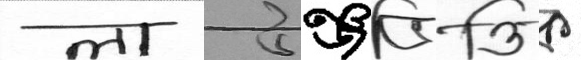

In [63]:
def generate_word(word, grapheme_dict, transform_fn=None, train=True, train_split=0.8):
    
    # random.seed(1)
    
    grapheme_parts = extract_graphemes(normalize_word(word))
    
    grapheme_imgs = []
    # padded_graphemes = []

    if train:
        for i in grapheme_parts:
            l = int(train_split * len(grapheme_dict[i]))
            img = cv2.imread(random.choice(grapheme_dict[i][:l]), cv2.IMREAD_GRAYSCALE)
            grapheme_imgs.append(img) 
            # padded_grapheme = pad_grapheme(img, i)
            # padded_graphemes.append(padded_grapheme)
    else:
        for i in grapheme_parts:
            l = int((1-train_split) * len(grapheme_dict[i]))
            img = cv2.imread(random.choice(grapheme_dict[i][l:]), cv2.IMREAD_GRAYSCALE)
            grapheme_imgs.append(img)
            # padded_grapheme = pad_grapheme(img, i)
            # padded_graphemes.append(padded_grapheme)

#     for i in grapheme_imgs:
#         print(i)
#         image = Image.open(i)
#         display(image)
#         print(np.array(image).shape)
    
    if transform_fn != None:
        grapheme_imgs = [transform(image=x)['image'] for x in grapheme_imgs]
        # padded_graphemes = [transform(image=x)['image'] for x in padded_graphemes]
        
    images =  [Image.fromarray(x) for x in grapheme_imgs]
    # images =  [Image.fromarray(x) for x in padded_graphemes]
    
    images =  [x.resize((x.size[-2],60)) for x in images]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_img = Image.new('L', (total_width, max_height))
    
    x_offset = 0
    for im in images:
      new_img.paste(im, (x_offset, 0))
      x_offset += im.size[0]
        
    return new_img


transform = A.Compose([
    A.augmentations.transforms.OpticalDistortion(distort_limit=0.5, p=1),
    A.ElasticTransform(alpha=1, sigma=0, alpha_affine=0, p=1),
#     A.imgaug.transforms.IAAPerspective(scale=(0.07, 0.07), p=0),
#     A.augmentations.transforms.Rotate(limit=10, p=0)
])

display(generate_word("লাউঞ্জভিত্তিক", grapheme_dict))
# display(generate_word("লাউঞ্জভিত্তিক", grapheme_dict, transform))

In [ ]:
def generate_train_set(words, grapheme_dict, multiplicity=4):
    
    try:
        # Create  Directory
        os.mkdir(os.path.join(DATA_DIR, "synhw_trainset/"))
    except FileExistsError:
        ##print if directory already exists
        print("Directory already exists.")
        
    transform = A.Compose([
    A.augmentations.transforms.OpticalDistortion(distort_limit=0.5, p=0.1),
    A.ElasticTransform(alpha=1, sigma=0, alpha_affine=0, p=0.2),
    # A.imgaug.transforms.IAAPerspective(scale=(0.07, 0.07), p=0),
    # A.augmentations.transforms.Rotate(limit=10, p=0)
    ])
    
    id = 0
    random.shuffle(words)
    for m in range(multiplicity):
        for word in tqdm(words):
            
            generated_word = generate_word(word, grapheme_dict) 
            generated_word.save(os.path.join(DATA_DIR, "synhw_trainset/"+str(id)+'_'+str(word)+'.jpg'))
            id += 1

generate_train_set(syn_wordlist, grapheme_dict)

In [71]:
def generate_synthetic_set(words, grapheme_dict, istrain=True, multiplicity=1):
    
    random.shuffle(words)
    
    if istrain: set_type = 'train'
    else: set_type = 'valid'
 
    try:
        # Create  Directory
        os.mkdir(os.path.join(DATA_DIR, "synthetic_hw/{}/".format(set_type)))
    except FileExistsError:
        shutil.rmtree(os.path.join(DATA_DIR, "synthetic_hw/{}/".format(set_type)))
        os.remove(os.path.join(DATA_DIR, "synthetic_hw/{}_labels.txt".format(set_type)))
        os.makedirs(os.path.join(DATA_DIR, "synthetic_hw/{}/".format(set_type)))
        
    with open(os.path.join(DATA_DIR, "synthetic_hw/{}_labels.txt".format(set_type)), "a", encoding="utf8") as f:
        id = 1
        for m in range(multiplicity):
            for word in tqdm(words):
                generated_word = generate_word(word, grapheme_dict, train=istrain) 
                #generated_word.save(os.path.join(DATA_DIR, "valid/"+str(id)+'_'+str(word)+'.jpg'))
                file_name = "{}.jpg".format(id)
                generated_word.save(os.path.join(DATA_DIR, "synthetic_hw/{}/{}".format(set_type, file_name)))
                f.write("{} {}\n".format(file_name, str(word)))
                id += 1

In [72]:
print("Generating Validation Set:")
generate_synthetic_set(syn_wordlist_valid, grapheme_dict, istrain=False, multiplicity=4)
print("Generating Training Set:")
generate_synthetic_set(syn_wordlist_train, grapheme_dict, istrain=True, multiplicity=4)

Generating Validation Set:


100%|████████████████████████████████████████████████████████| 54890/54890 [01:28<00:00, 621.28it/s]


Generating Training Set:


100%|██████████████████████████████████████████████████████| 555959/555959 [18:06<00:00, 511.78it/s]


Total Train images: 2223836

101


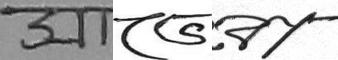

102


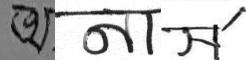

103


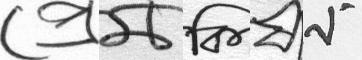

104


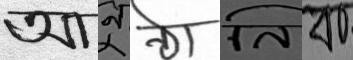

105


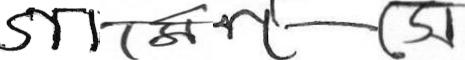

In [75]:
train_image_files = glob.glob(os.path.join(DATA_DIR, "synthetic_hw/train/*"))
print("Total Train images: " + str(len(train_image_files)))
print()

for i in train_image_files[100:105]:
    print(i.split('/')[-1].split('.')[-2].split('_')[-1])
    display(IPython.display.Image(filename=i))

Total Validation images: 219560

1


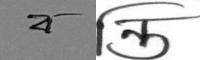

2


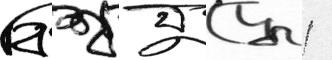

3


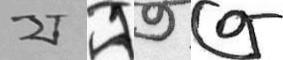

4


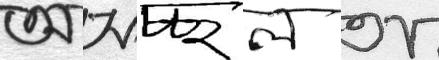

5


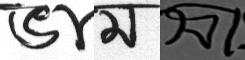

In [76]:
val_image_files = glob.glob(os.path.join(DATA_DIR, "synthetic_hw/valid/*"))
print("Total Validation images: " + str(len(val_image_files)))
print()

for i in val_image_files[:5]:
    print(i.split('/')[-1].split('.')[-2].split('_')[-1])
    display(IPython.display.Image(filename=i))

### Get Number of Classes

In [35]:
def extract_graphemes(word):
    
    forms_cluster = {'ক': ['ক', 'ট', 'ত', 'ন', 'ব', 'ম', 'র', 'ল', 'ষ', 'স'],
                     'গ': ['গ', 'ধ', 'ন', 'ব', 'ম', 'ল'],
                     'ঘ': ['ন'],
                     'ঙ': ['ক', 'খ', 'গ', 'ঘ', 'ম'],
                     'চ': ['চ', 'ছ', 'ঞ'],
                     'জ': ['জ', 'ঝ', 'ঞ', 'ব'],
                     'ঞ': ['চ', 'ছ', 'জ', 'ঝ'],
                     'ট': ['ট', 'ব'],
                     'ড': ['ড'],
                     'ণ': ['ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ব', 'ম'],
                     'ত': ['ত', 'থ', 'ন', 'ব', 'ম', 'র'],
                     'থ': ['ব'],
                     'দ': ['গ', 'ঘ', 'দ', 'ধ', 'ব', 'ভ', 'ম'],
                     'ধ': ['ন', 'ব'],
                     'ন': ['জ', 'ট', 'ঠ', 'ড', 'ত', 'থ', 'দ', 'ধ', 'ন', 'ব', 'ম', 'স'],
                     'প': ['ট', 'ত', 'ন', 'প', 'ল', 'স'],
                     'ফ': ['ট', 'ল'],
                     'ব': ['জ', 'দ', 'ধ', 'ব', 'ভ', 'ল'],
                     'ভ': ['র'],
                     'ম': ['ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'ল'],
                     'ল': ['ক', 'গ', 'ট', 'ড', 'প', 'ফ', 'ব', 'ম', 'ল', 'স'],
                     'শ': ['চ', 'ছ', 'ত', 'ন', 'ব', 'ম', 'ল'],
                     'ষ': ['ক', 'ট', 'ঠ', 'ণ', 'প', 'ফ', 'ব', 'ম'],
                     'স': ['ক', 'খ', 'ট', 'ত', 'থ', 'ন', 'প', 'ফ', 'ব', 'ম', 'ল'],
                     'হ': ['ণ', 'ন', 'ব', 'ম', 'ল'],
                     'ড়': ['গ']}
    
    forms_tripple_cluster = {'ক্ষ': ['ণ', 'ম'], 'ঙ্ক': ['ষ'], 'চ্ছ': ['ব'], 'জ্জ': ['ব'],
                             'ত্ত': ['ব'], 'দ্দ': ['ব'], 'দ্ধ': ['ব'], 'দ্ভ': ['র'],
                             'ন্ত': ['ব'], 'ন্দ': ['ব'], 'ম্প': ['ল'], 'ম্ভ': ['র'],
                             'ষ্ক': ['র'], 'স্ক': ['র'], 'স্ত': ['ব', 'র'], 'স্প': ['ল']}
    
    chars = []
    i = 0
    adjust = 0
    
    while(i < len(word)):
        if i+1 < len(word) and word[i+1] == '্':
            if word[i] == 'র':
                chars.append('র্')
                adjust = 0
                i+=2
            elif i+2 < len(word) and word[i+2] == 'য':
                chars.append(word[i-adjust:i+1])
                chars.append('্য')
                adjust = 0
                i+=3
            elif i+2 < len(word) and word[i+2] == 'র':
                # Treat '্র' as a seperate grapheme
                chars.append(word[i-adjust:i+1])
                chars.append('্র')
                # Keep '্র' icluded in the cluster
                # chars.append(word[i-adjust:i+3])
                if i+3 < len(word) and word[i+3] == '্' and i+4 < len(word) and word[i+4] == 'য':    
                    chars.append('্য')
                    i+=5
                else:
                    i+=3
                adjust = 0
            elif i+2 < len(word) and adjust!=0 and word[i-adjust:i+1] in forms_tripple_cluster \
                and word[i+2] in forms_tripple_cluster[word[i-adjust:i+1]]:
                if i+3 < len(word) and word[i+3] == '্':
                    adjust += 2
                    i+=2
                else:
                    chars.append(word[i-adjust:i+3])
                    adjust = 0
                    i+=3
            elif i+2 < len(word) and adjust==0 and word[i] in forms_cluster and word[i+2] in forms_cluster[word[i]]:
                if i+3 < len(word) and word[i+3] == '্':
                    adjust += 2
                    i+=2
                else:
                    chars.append(word[i-adjust:i+3])
                    adjust = 0
                    i+=3
            else:
                chars.append(word[i-adjust:i+1])
                chars.append('্')
                adjust = 0
                i+=2

        else:
            chars.append(word[i:i+1])
            i+=1

    
    #print(word)
    #print(chars)

    return chars



#Break every character
# def extract_graphemes(word):
    
#     return list(word)

In [36]:
with open(os.path.join(DATA_DIR, "synthetic_hw/synhw_wordlist_train.txt"), "r") as f:
    syn_wordlist_train = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
syn_wordlist_train = [x.strip() for x in syn_wordlist_train]

grapheme_freq = {}

for word in syn_wordlist_train:
    graphemes = extract_graphemes(normalize_word(word))
    for grapheme in graphemes:
        try:
            grapheme_freq[grapheme] += 1
        except KeyError:
            grapheme_freq[grapheme] = 1

print(len(grapheme_freq))
grapheme_list = sorted(grapheme_freq.items(), key=lambda x:x[1], reverse=True)
grapheme_freq = dict(grapheme_list)
print(grapheme_freq)
print()
print(sorted(grapheme_freq))

200
{'া': 488062, 'ি': 290479, 'র': 270887, 'ে': 260510, 'ন': 180557, 'ক': 163509, 'ল': 138843, 'ব': 130517, 'ম': 128557, 'স': 128018, 'ু': 109310, 'ত': 105228, 'প': 100172, 'ো': 85056, 'য়': 84138, '্র': 69922, 'গ': 69067, ',': 67597, 'দ': 67515, 'ট': 65602, 'ী': 62318, 'ই': 58209, 'জ': 58194, 'হ': 57631, '্য': 54122, 'শ': 51699, '-': 49989, 'র্': 47666, '।': 43411, 'ভ': 40555, 'ও': 31907, 'চ': 30844, 'ড': 30844, 'আ': 29310, 'এ': 28668, 'অ': 26613, 'ফ': 25836, 'উ': 25515, 'ণ': 22785, 'ং': 18895, 'ধ': 18514, 'খ': 17875, 'ূ': 17428, 'য': 15654, 'থ': 14313, 'ড়': 13825, 'ৃ': 10977, 'ছ': 10562, 'ন্দ': 10036, 'স্ট': 10009, 'ষ': 9778, '১': 9521, 'ক্ষ': 9201, 'ন্ত': 8439, '০': 8134, 'ঙ্গ': 7494, 'স্ত': 7222, 'ন্ড': 6893, 'ন্ট': 6640, 'ঘ': 6222, 'ঁ': 6047, 'ক্ত': 5945, '২': 5460, 'ৌ': 5308, 'স্থ': 4883, 'ত্ত': 4731, 'ষ্ট': 4719, 'স্ক': 4475, 'ৈ': 4256, 'ক্স': 4248, '৯': 4221, 'ঠ': 4000, '৩': 3806, 'স্ব': 3786, 'ন্স': 3779, '৫': 3761, 'ম্প': 3728, 'ৎ': 3714, 'দ্ধ': 3635, '৪': 3544, '৮': 3433, 'ঞ